Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Theta Space.ipynb")

HSP_T (generic function with 1 method)

In [2]:
using QuantumOptics

## Initial Parameters

In [3]:
Nx=4;Ny=4;N=Nx*Ny;q=Ny;PN=2;T_size=10;

## Create Single-Particle Operator

In [4]:
function Op_Sp(Nx, Ny, alpha, Tx, Ty)
        
    H_T = HSP_T(Nx, Ny, alpha, Tx, Ty, 0)
    
    basis = NLevelBasis(N) 
    
    H = SparseOperator(basis)
    
    for m in 1:N
        for n in 1:N
            H = H + H_T[m,n] * transition(basis, m, n)
        end
    end
    
    return H
end

Op_Sp (generic function with 1 method)

In [5]:
# CHECK: Operator Form
using LinearAlgebra
Tx=Ty=0
op = Op_Sp(Nx, Ny, 1/q, Tx, Ty)
eigenenergies(dense(op)) == eigvals(HSP_T(Nx, Ny, 1/q, Tx, Ty, 0))

true

## Create Many-Basis for Hard-Core Interaction

In [6]:
basis = NLevelBasis(N)
states = fermionstates(basis, PN)
basis_mb = ManyBodyBasis(basis, states)

function get_mb_op(basis_mb, op)
    H_mb2 = SparseOperator(basis_mb) 
    for m in 1:N
        for n in 1:N
            H_mb2 += op.data[m,n] * transition(basis_mb, m, n)
        end
    end
    
    return H_mb2
end

H_mb = get_mb_op(basis_mb, op);

In [7]:
# CHECK: MB Structure (PN=1)
eigenenergies(dense(H_mb)) == eigvals(HSP_T(Nx, Ny, 1/q, Tx, Ty, 0))

false

## Crete Mesh of Twisted-Angle Space

\begin{equation}
\theta_\mu = \frac{2\pi}{N_\theta}n_\mu
\end{equation}

In [8]:
dx=2*pi/T_size
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

## Energies of Many-Body Hofstadter Model

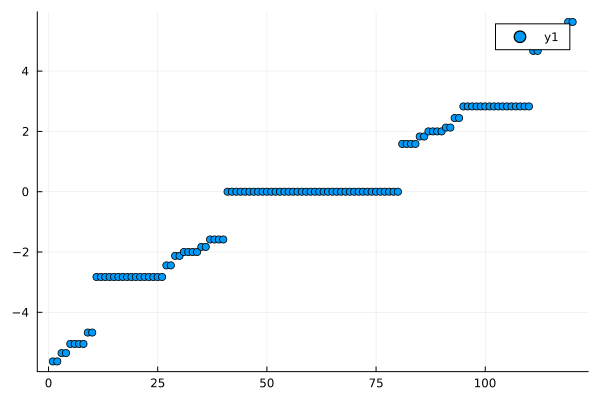

In [9]:
using Plots
E = eigenenergies(dense(H_mb))
plot(1:length(E),E,seriestype=:scatter)

# Cherns

Berry Curvature:
\begin{equation}
\mathcal{F}(\vec{\theta}) = \log \left( U_x(\vec{\theta})U_y(\vec{\theta}+\delta_x)U_x(\vec{\theta}+\delta_y)^{-1}U_y(\vec{\theta})^{-1} \right)
\end{equation}
Link variables:
\begin{equation}
U_\mu(\vec{\theta}) = \frac{
det \left( \Phi(\vec{\theta})^\dagger \Phi(\vec{\theta}+\delta_\mu) \right) 
}{
| det \left(\Phi(\vec{\theta})^\dagger \Phi(\vec{\theta}+\delta_\mu) \right) |} , \quad \delta_x = \left(\frac{2\pi}{N_{\theta}},0 \right), \delta_y = \left(0, \frac{2\pi}{N_{\theta}}\right)
\end{equation}
Chern Number:
\begin{equation}
\mathcal{C} = \frac{1}{2\pi i} \sum_{\vec{\theta}} \mathcal{F}(\vec{\theta})
\end{equation}

In [10]:
# executeme

function Chern_Nums(Tx, Ty, n1, n2)
    
    Sum=0
    
    for tx in range(start=1, stop=length(Tx))
        for ty in range(start=1, stop=length(Ty))
            
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w1, v1 = eigen(dense(H_mb).data)
            i = sortperm(w1, by=real);w1 = w1[i];v1 = v1[:,i]
            v1 = v1[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty])
            H_mb = get_mb_op(basis_mb, op)
            w2, v2 = eigen(dense(H_mb).data)
            i = sortperm(w2, by=real);w2 = w2[i];v2 = v2[:,i]
            v2 = v2[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx], Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w3, v3 = eigen(dense(H_mb).data)
            i = sortperm(w3, by=real);w3 = w3[i];v3 = v3[:,i]
            v3 = v3[:,n1:n2]
            
            #------------------------------------
            op = Op_Sp(Nx, Ny, 1/q, Tx[tx]+dx, Ty[ty]+dy)
            H_mb = get_mb_op(basis_mb, op)
            w4, v4 = eigen(dense(H_mb).data)
            i = sortperm(w4, by=real);w4 = w4[i];v4 = v4[:,i]
            v4 = v4[:,n1:n2]
            
            #----------LINK VARIABLES------------
            U1=det(adjoint(v1)*v2)
            U1=U1/abs(U1)
            U2=det(adjoint(v2)*v4)
            U2=U2/abs(U2)
            U3=det(adjoint(v3)*v4)
            U3=U3/abs(U3)
            U4=det(adjoint(v1)*v3)
            U4=U4/abs(U4)
            
            #----------BERRY CURVATURE-----------
            F=log(U1*U2*1/U3*1/U4)
            Sum=Sum+F
            
        end
    end
    
    return 1/(2*pi*1im)*Sum
end

Chern_Nums (generic function with 1 method)

In [11]:
Chern_Nums(Tx, Ty, 1, 2)

1.0000000000000002 + 3.5475815807404787e-16im